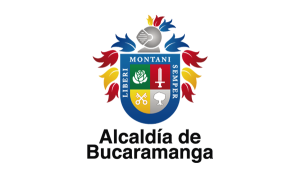

## Secretaría de Salud y Ambiente
---







<a href="https://colab.research.google.com/github/JotaRodriguez94/Forecasting_COVID_BGA/blob/main/MODELS_ML_DL_COVID_19_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

## Implementación y ajuste de modelos ML y DL para la predicción de casos COVID-19 en la ciudad de Bucaramanga.

In [1]:
#@title Importar dependencias
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'

# download the code
!git clone -q https://github.com/JotaRodriguez94/Forecasting_COVID_BGA.git
# Uncomment this block to install necessary dependencies.
#!pip install -q statsmodels
!pip install -q xgboost
!pip install -q hyperopt
!pip install -U -q keras-tuner

import gc
import tqdm
import shutil
import IPython
import imageio
import warnings
import datetime
import importlib
import numpy as np
import xgboost as xgb
import pandas as pd
import pickle as pkl
import seaborn as sns
import kerastuner as kt
import tensorflow as tf
from sklearn.svm import SVR
from sklearn import metrics
import matplotlib.pyplot as plt
from collections import defaultdict

from time import sleep
from collections import defaultdict
from IPython.core.display import display, HTML
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, STATUS_FAIL

from Forecasting_COVID_BGA import dataset, utils
from Forecasting_COVID_BGA.models.xgboost import train_xgb, optimize_xgb, optimize_direct_xgb, mape, load_direct_model

warnings.filterwarnings('once')
#importlib.reload(utils);
gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus)>0:
    tf.config.experimental.set_memory_growth(gpus[0], True)

seed = 7
plt.style.use('ggplot')
np.random.seed(seed=seed)

     |████████████████████████████████| 71kB 5.4MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Descargar los datos y procesarlos

In [2]:
#@title 
!wget -q https://www.datos.gov.co/api/views/gt2j-8ykr/rows.csv -O Casos_positivos_de_COVID-19_en_Colombia.csv
data_colombia = pd.read_csv('Casos_positivos_de_COVID-19_en_Colombia.csv')
!wget -q https://covid.ourworldindata.org/data/owid-covid-data.xlsx -O owid-covid-data.xlsx  
data = pd.read_excel('owid-covid-data.xlsx')


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (14,17,19,20,22) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Parámetros de entrenamiento

Max value in days 335

Params:


{'batch_size': 1,
 'col_test_series': 0,
 'differentiation': False,
 'final_date': datetime.datetime(2020, 11, 28, 0, 0),
 'future_window': 14,
 'initial_date': datetime.datetime(2020, 3, 1, 0, 0),
 'lag': 14,
 'lagging': True,
 'mode': 'testing',
 'past_window': 14,
 'shuffle_buffer': 10000,
 'smooth': 7,
 'smoothing': True,
 'standarization': True,
 'stateful': False,
 'train_final_date': datetime.datetime(2020, 9, 21, 0, 0)}

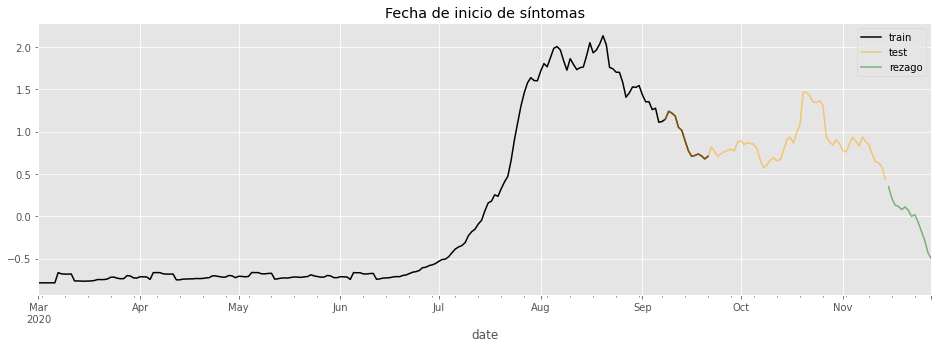

In [56]:
##@title

initial_date = '2020-03-01' #@param {type:"date"}
train_final_date = '2020-09-21' #@param {type:"date"}
define_final = False #@param {type:"boolean"}
final_date = '2020-11-16' #@param {type:"date"}
lagging = True #@param {type:"boolean"}
lag = 14 #@param {type:"integer"}
smoothing = True #@param {type:"boolean"}
smooth_window = 7 #@param {type:"integer"}
standarization = True #@param {type:"boolean"}
mode = 'testing' #@param ["testing", "forecasting"]
Tipo_fecha = 'Fecha de inicio de síntomas' #@param ['Fecha de notificación','Fecha de inicio de síntomas','Fecha de diagnóstico']

# preproccesing data
df_join = utils.preproccesing_data(data, data_colombia, Tipo_fecha)
countries_top = ['Argentina', 'Bangladesh', 'Belgium', 'Brazil', 'Canada', 'Chile', 'Czech Republic',
'France', 'Germany', 'India', 'Indonesia', 'Iran', 'Iraq', 'Israel', 'Italy', 'Mexico',
'Morocco', 'Netherlands', 'Pakistan', 'Peru', 'Philippines', 'Poland', 'Romania',
'Russia', 'Saudi Arabia', 'South Africa', 'Spain', 'Turkey', 'Ukraine', 'United Kingdom',
'United States']
dep_top = ['ANTIOQUIA', 'ATLANTICO', 'CUNDINAMARCA', 'SANTANDER', 'VALLE']
cities_top = ['BARRANQUILLA', 'BOGOTA', 'BUCARAMANGA', 'CALI', 'CARTAGENA', 'MEDELLIN']
series = cities_top + dep_top + countries_top
df_join = df_join[series]


# Date range to select the series.
initial_date = datetime.datetime.strptime(initial_date, '%Y-%m-%d')
if define_final:
    final_date = datetime.datetime.strptime(final_date, '%Y-%m-%d')
else:    
    final_date = datetime.datetime.strptime(df_join.loc[~df_join['BUCARAMANGA'].isna()].index.values[-1].astype(str)[:10], '%Y-%m-%d')
# Range of dates for training and testing (last window in the future plus 7 days)
train_final_date = datetime.datetime.strptime(train_final_date, '%Y-%m-%d')
#Dictionary with necessary parameters
base_dset_params = dict(batch_size=1,
                        past_window=14,
                        future_window=14,
                        shuffle_buffer=10000,
                        col_test_series=0,
                        stateful = False,
                        standarization = standarization,
                        differentiation = False,
                        smoothing = smoothing,
                        smooth = smooth_window,
                        initial_date = initial_date,
                        final_date = final_date,
                        train_final_date=train_final_date,
                        lagging=lagging,
                        lag = lag,
                        mode=mode)

name_folder = str(train_final_date).split(' ')[0]+\
                '_'+str(base_dset_params['past_window'])+\
                '_'+str(base_dset_params['future_window'])+\
                '_'+str(base_dset_params['standarization'])+\
                '_'+str(base_dset_params['smoothing'])+\
                '_'+str(base_dset_params['differentiation'])

# select all data until the date is fixed
final_data = df_join.loc[(df_join.index >= initial_date)
                         & (df_join.index <= final_date)]
                        
# serie smoothing
if base_dset_params['smoothing']:
    final_data = final_data.rolling(base_dset_params['smooth']).mean().fillna(0)

# data split
final_data_train = final_data.loc[final_data.index <= train_final_date]
# for test set is necessary select de last train window
final_data_test = final_data.loc[final_data.index > (train_final_date-datetime.timedelta(days=base_dset_params['past_window']))]
# train
bga_data_train, bga_scaler = dataset.series_transformer(
    final_data_train['BUCARAMANGA'].to_frame(),
    standarization=standarization,
    scaler=None)
# test
# if there is lag then remove the windows lag size
if base_dset_params['lagging']:
    final_data_test_ml = final_data_test.loc[final_data_test.index <= final_date-datetime.timedelta(days=base_dset_params['lag'])] 
else:
    final_data_test_ml = final_data_test

if base_dset_params['standarization']:
    bga_data_test, bga_scaler = dataset.series_transformer(
        final_data_test_ml['BUCARAMANGA'].to_frame(),
        standarization=base_dset_params['standarization'],
        scaler=bga_scaler)
    if base_dset_params['lagging']:
        lag_values = final_data_test.loc[final_data_test.index > final_date-datetime.timedelta(days=base_dset_params['lag'])]['BUCARAMANGA'].to_frame()
        bga_data_test_lag, bga_scaler_lag = dataset.series_transformer(
                                                lag_values,
                                                standarization=base_dset_params['standarization'],
                                                scaler=bga_scaler)
else:
    bga_data_test, bga_scaler = dataset.series_transformer(
    final_data_test_ml['BUCARAMANGA'].to_frame(),
    standarization=base_dset_params['standarization'],
    scaler=None) 

    if base_dset_params['lagging']:
        lag_values = final_data_test.loc[final_data_test.index > final_date-datetime.timedelta(days=base_dset_params['lag'])]['BUCARAMANGA'].to_frame()
        bga_data_test_lag, bga_scaler_lag = dataset.series_transformer(
                                                lag_values,
                                                standarization=base_dset_params['standarization'],
                                                scaler=None)      

ax = bga_data_train.rename(columns={'BUCARAMANGA':'train'}).plot(figsize=(16,5),
                                                                 color='black');
bga_data_test.rename(columns={'BUCARAMANGA':'test'}).plot(ax=ax, 
                                                          color='orange',
                                                          alpha=0.5);

if base_dset_params['lagging']:
    bga_data_test_lag.rename(columns={'BUCARAMANGA':'rezago'}).plot(ax=ax, 
                                                          color='green',
                                                          alpha=0.5);
ax.set_title(Tipo_fecha)
#ax.set_title('Fecha inicio de síntomas 15 días después')
#plt.vlines(datetime.datetime.strptime('2020-11-16', '%Y-%m-%d'), 0,
#           bga_data_train.max().values[0]+70, 
#           colors='blue', 
#           linestyles='dashed')
print('\nParams:')
#ax.get_legend().remove()
base_dset_params                                                       

## Modelos de aprendizaje de máquina (ML)

## 1. Restructuración de datos para el enfoque directo

In [57]:
#@title 
ml_direct_train_dset_params = utils.copy_and_modify_dict(base_dset_params, {})
ml_direct_test_dset_params = utils.copy_and_modify_dict(base_dset_params,
                                                  {'shuffle_buffer': 0})

ml_direct_bga_dset_train = dataset.windowed_dataset(bga_data_train,
                                            ml_direct_train_dset_params,
                                            tf_dset=False,
                                            direct_dset=True)

ml_direct_bga_dset_test = dataset.windowed_dataset(bga_data_test,
                                           ml_direct_test_dset_params,
                                           tf_dset=False,
                                           direct_dset=True)

### A. XGBoost - Directo univariable (serie Bucaramanga)

In [58]:
#@title
# hyper optimization
xgb_dir_params, xgb_dir_trials = optimize_direct_xgb(
    ml_direct_bga_dset_train['x'], ml_direct_bga_dset_train['y'], max_evals=50)

# Use the best params to train the best Direct XGBoost
xgb_dir_results = []
for idx, xgb_dir_param in enumerate(xgb_dir_params):
    xgb_dir_results.append(train_xgb(xgb_dir_param, ml_direct_bga_dset_train['x'][idx], 
                                     ml_direct_bga_dset_train['y'][idx]))
    
# Compute the Root Mean Square Error
for idx, xgb_dir_res in enumerate(xgb_dir_results):
    xgb_model_dir = xgb_dir_res["model"]
    xgb_preds_dir = xgb_model_dir.predict(ml_direct_bga_dset_test['x'][idx])
    cv_score = min([
        f["loss"] for f in xgb_dir_trials[idx].results if f["status"] == STATUS_OK
    ])
    test_score = metrics.mean_absolute_error(ml_direct_bga_dset_test['y'][idx], xgb_preds_dir)

    print(
        f"Direct Model {idx + 1}: Mean absolute error cross-validation/test: {cv_score:.4f} / {test_score:.4f}"
    )    

Optimizing XGBoosts models using a direct approach...
Finding best params for XGBoost model 0...
100%|██████████| 50/50 [00:34<00:00,  1.46it/s, best loss: 0.005474918244049695]

    Best parameters:
        learning_rate: 0.12225674634683276 
        n_estimators: 990.0
        max_depth: 1.0
        sub_sample: 0.8595795316531808
        gamma: 11.0
    
Finding best params for XGBoost model 1...
100%|██████████| 50/50 [00:35<00:00,  1.40it/s, best loss: 0.01018090181181127]

    Best parameters:
        learning_rate: 0.15131945811336986 
        n_estimators: 450.0
        max_depth: 3.0
        sub_sample: 0.8478085916145347
        gamma: 35.0
    
Finding best params for XGBoost model 2...
100%|██████████| 50/50 [00:29<00:00,  1.72it/s, best loss: 0.01222579193698874]

    Best parameters:
        learning_rate: 0.12800791676480724 
        n_estimators: 170.0
        max_depth: 2.0
        sub_sample: 0.9448614113849381
        gamma: 12.0
    
Finding best params for XGBoost m

### Guardar el modelo y verificar su reproducibilidad

In [59]:
#@title
# save the models
path = os.path.join('Forecasting_COVID_BGA/trained_models/xgb_direct/', name_folder, '')  
os.makedirs(path, exist_ok=True)

scalerfile = path+'scaler.pkl'
pkl.dump(bga_scaler, open(scalerfile, 'wb'),  protocol=pkl.HIGHEST_PROTOCOL)

for idx, xgb_dir_res in enumerate(xgb_dir_results):
    xgb_model_dir = xgb_dir_res["model"]
    xgb_model_dir.save_model(path+'/xgb_direct_{}_model'.format(idx))
# Load and tests if all models give the same results
for idx, xgb_dir_res in enumerate(xgb_dir_results):
    # Load the trained and saved models.
    xgb_dir_test = xgb.XGBRegressor()
    xgb_dir_test.load_model(path+'/xgb_direct_{}_model'.format(idx))

    # Compare predictions
    xgb_model_dir = xgb_dir_res["model"]
    xgb_preds_dir = xgb_model_dir.predict(ml_direct_bga_dset_test['x'][idx])
    xgb_preds_test = xgb_dir_test.predict(ml_direct_bga_dset_test['x'][idx])
    print('Predictions are equal:',
          np.array_equal(xgb_preds_dir, xgb_preds_test))

Predictions are equal: True
Predictions are equal: False
Predictions are equal: True
Predictions are equal: True
Predictions are equal: True
Predictions are equal: True
Predictions are equal: True
Predictions are equal: True
Predictions are equal: True
Predictions are equal: True
Predictions are equal: True
Predictions are equal: True
Predictions are equal: False
Predictions are equal: True


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: ResourceWarning: unclosed file <_io.BufferedWriter name='Forecasting_COVID_BGA/trained_models/xgb_direct/2020-09-21_14_14_True_True_False/scaler.pkl'>
  import sys


#### Cargar el modelo y gráficar las predicciones

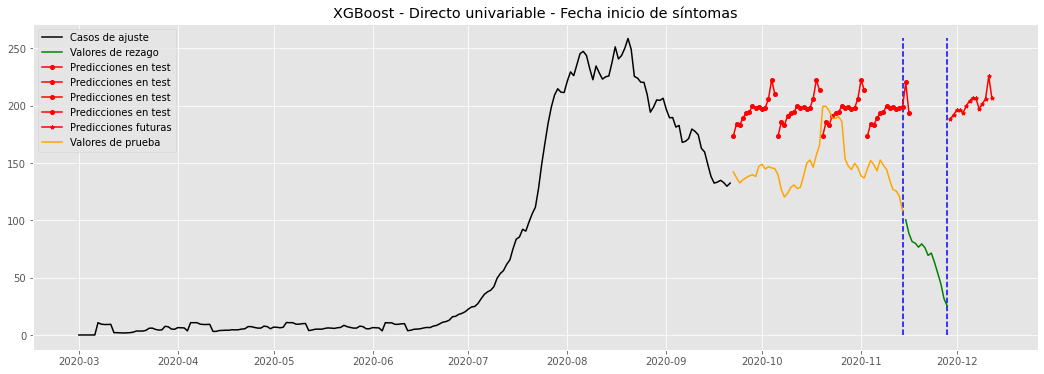

In [60]:
#@title
xgb_direct_models = load_direct_model(path)
fig_plot = utils.plot_serie_with_next_window_prediction(xgb_direct_models,
                                       final_data_train,
                                       final_data_test,
                                       bga_scaler,
                                       base_dset_params,
                                       final_data_test.keys().values.tolist().index('BUCARAMANGA'),
                                       recursive=False,
                                       title='XGBoost - Directo univariable - Fecha inicio de síntomas')

## 2. Restructuración de datos para el enfoque recursivo

In [50]:
#@title 
ml_rec_train_dset_params = utils.copy_and_modify_dict(base_dset_params,
                                                {'future_window': 1})
ml_rec_test_dset_params = utils.copy_and_modify_dict(base_dset_params, {
    'shuffle_buffer': 0,
    'future_window': 1
})

ml_rec_bga_dset_train = dataset.windowed_dataset(bga_data_train,
                                         ml_rec_train_dset_params,
                                         tf_dset=False,
                                         direct_dset=False)

ml_rec_bga_dset_test = dataset.windowed_dataset(bga_data_test,
                                        ml_rec_test_dset_params,
                                        tf_dset=False,
                                        direct_dset=False)

### B. SVR - Recursivo univariable (serie Bucaramanga)

In [51]:
#@title
svr_rec_dir = os.path.join('Forecasting_COVID_BGA/trained_models/svr_recursive/', name_folder, '') 
#if os.path.exists(svr_rec_dir): shutil.rmtree(svr_rec_dir)
os.makedirs(svr_rec_dir, exist_ok=True)

def build_model(hp):
    model = SVR(kernel=hp.Choice(
        'kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
                degree=hp.Int('degree', 1, 10, step=1),
                gamma=hp.Choice('gamma', ['scale', 'auto']),
                coef0=hp.Float('coef0', 1e-4, 1, sampling='log'),
                C=hp.Float('C', 1e-4, 10, sampling='linear'),
                epsilon=hp.Float('epsilon', 1e-4, 1e-1, sampling='log'))
    return model

# optimization
scoring = metrics.make_scorer(metrics.mean_squared_error)
tuner = kt.tuners.Sklearn(oracle=kt.oracles.BayesianOptimization(
        objective=kt.Objective('score', 'min'), max_trials=100, seed=seed),
        hypermodel=build_model, 
        directory=svr_rec_dir, 
        scoring=scoring,
        project_name='svr_tuner',
        cv=TimeSeriesSplit(5),
        metrics = metrics.mean_absolute_error ,
        overwrite = True
        )

tuner.search(ml_rec_bga_dset_train['x'], 
             ml_rec_bga_dset_train['y'])
## get the best model
best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print('Best parameters:')
print(vars(best_hyperparameters)['values'])
svr_preds_rec = best_model.predict(ml_rec_bga_dset_test['x'])
# evaluate
test_score = metrics.mean_absolute_error(ml_rec_bga_dset_test['y'], svr_preds_rec)
print(
    f"Mean absolute error test: {test_score:.4f}"
)

Trial 100 Complete [00h 00m 00s]
score: 0.13329375729624085

Best score So Far: 0.128839547659804
Total elapsed time: 00h 02m 06s
INFO:tensorflow:Oracle triggered exit
Best parameters:
{'kernel': 'rbf', 'degree': 9, 'gamma': 'scale', 'coef0': 0.008413690576806512, 'C': 0.30565014634172183, 'epsilon': 0.0005282098596237646}
Mean absolute error test: 0.3958


### Guardar el modelo y verificar su reproducibilidad

Mean absolute error test:  0.3958409699196525
Predictions are equal: True


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: ResourceWarning: unclosed file <_io.BufferedWriter name='Forecasting_COVID_BGA/trained_models/svr_recursive/2020-10-10_14_14_True_False_False/scaler.pkl'>


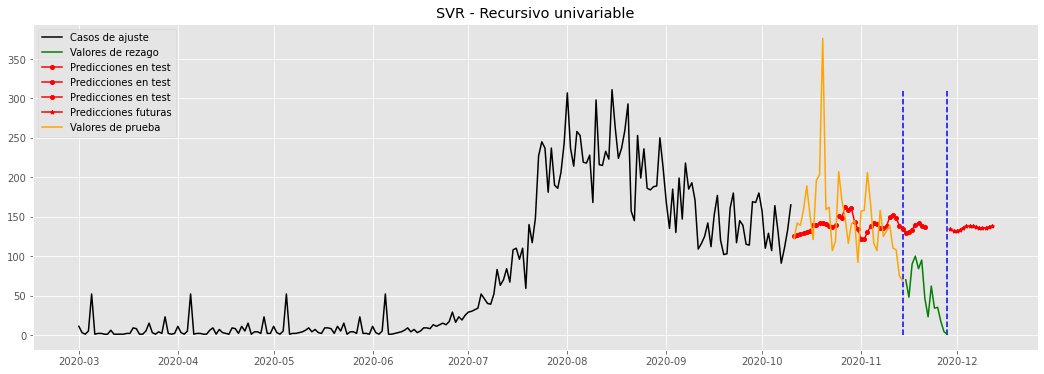

In [52]:
#@title 
#save the model
with open(svr_rec_dir+'svr_recursive_model.pkl', 'wb') as pickle_file:
    pkl.dump(best_model, pickle_file, protocol=pkl.HIGHEST_PROTOCOL)
#Load to test if it gives the same predictions    
with open(svr_rec_dir+'svr_recursive_model.pkl', 'rb') as pickle_file:
    svr_rec_test = pkl.load(pickle_file)

# test
svr_preds_rec = best_model.predict(ml_rec_bga_dset_test['x'])
svr_preds_test = svr_rec_test.predict(ml_rec_bga_dset_test['x'])
test_score = metrics.mean_absolute_error(ml_rec_bga_dset_test['y'], svr_preds_test)
print('Mean absolute error test: ', test_score)
print('Predictions are equal:',np.array_equal(svr_preds_rec, svr_preds_test))

scalerfile = svr_rec_dir+'scaler.pkl'
pkl.dump(bga_scaler, open(scalerfile, 'wb'),  protocol=pkl.HIGHEST_PROTOCOL)

# plots
fig_plot2 = utils.plot_serie_with_next_window_prediction(svr_rec_test,
                                       final_data_train,
                                       final_data_test,
                                       bga_scaler,
                                       base_dset_params,
                                       final_data_test.keys().values.tolist().index('BUCARAMANGA'),
                                       recursive=True,
                                       title='SVR - Recursivo univariable')

### D. XGBoost - Recursivo univariable (serie Bucaramanga)

In [ ]:
#@title
xgb_rec_params, xgb_rec_trials = optimize_xgb(ml_rec_bga_dset_train['x'],
                                              ml_rec_bga_dset_train['y'],
                                              max_evals=50)

xgb_rec_res = train_xgb(xgb_rec_params, ml_rec_bga_dset_train['x'],
                        ml_rec_bga_dset_train['y'])

# Compute Mean Square Error   
xgb_model_rec = xgb_rec_res["model"]
xgb_preds_rec = xgb_model_rec.predict(ml_rec_bga_dset_test['x'])
cv_score = min(
    [f["loss"] for f in xgb_rec_trials.results if f["status"] == STATUS_OK])
#test_score = mape(ml_rec_bga_dset_test['y'], xgb_preds_rec)
test_score = metrics.mean_absolute_error(ml_rec_bga_dset_test['y'], xgb_preds_rec)
print(
    f"mean absolute error cross-validation/test: {cv_score:.4f} / {test_score:.4f}"
)

100%|██████████| 50/50 [00:47<00:00,  1.06it/s, best loss: 0.010901564105855672]

    Best parameters:
        learning_rate: 0.024279844392977288 
        n_estimators: 660.0
        max_depth: 2.0
        sub_sample: 0.950320250900862
        gamma: 45.0
    
mean absolute error cross-validation/test: 0.0109 / 0.1674


### Guardar el modelo y verificar su reproducibilidad

Predictions are equal:  True


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: ResourceWarning: unclosed file <_io.BufferedWriter name='Forecasting_COVID_BGA/trained_models/xgb_recursive/2020-10-10_21_21_True_True_False/scaler.pkl'>
  """


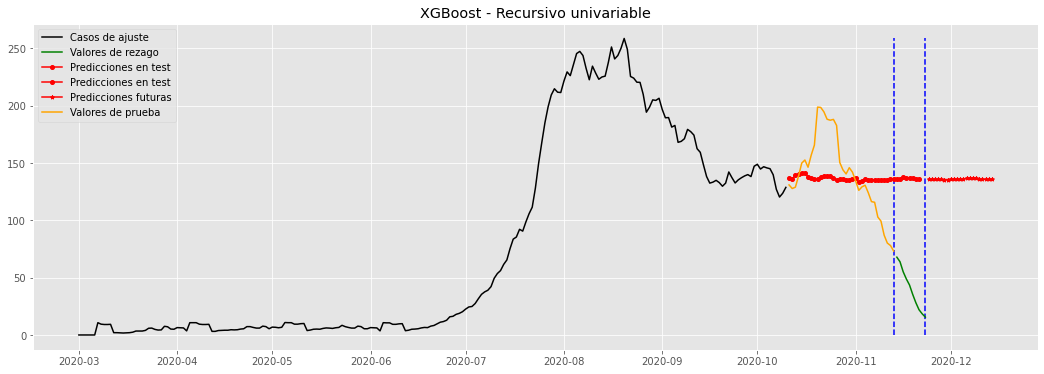

In [ ]:
#@title
xgb_rec_path = os.path.join('Forecasting_COVID_BGA/trained_models/xgb_recursive/', name_folder, '') 
os.makedirs(xgb_rec_path, exist_ok=True)
scalerfile = xgb_rec_path+'scaler.pkl'
pkl.dump(bga_scaler, open(scalerfile, 'wb'),  protocol=pkl.HIGHEST_PROTOCOL)
xgb_model_rec.save_model(xgb_rec_path+'xgb_recursive_model')
#Load to test if it gives the same predictions
xgb_rec_test = xgb.XGBRegressor()
xgb_rec_test.load_model(xgb_rec_path+'xgb_recursive_model')
xgb_preds_rec = xgb_model_rec.predict(ml_rec_bga_dset_test['x'])
xgb_preds_test = xgb_rec_test.predict(ml_rec_bga_dset_test['x'])
print('Predictions are equal: ',np.array_equal(xgb_preds_rec, xgb_preds_test))
#plot
fig_plor2 = utils.plot_serie_with_next_window_prediction(xgb_rec_test,
                                       final_data_train,
                                       final_data_test,
                                       bga_scaler,
                                       base_dset_params,
                                       final_data_test.keys().values.tolist().index('BUCARAMANGA'),
                                       recursive=True,
                                       title='XGBoost - Recursivo univariable')

## Modelos de aprendizaje profundo (DL)

## 3. Restructuración de datos para el enfoque directo univariable

In [12]:
#@title
dl_bga_dset_train = dataset.windowed_dataset(bga_data_train.values.reshape(-1,1).astype(np.float32),
                                            base_dset_params,
                                            tf_dset=True,
                                            direct_dset=None)

dl_bga_dset_test = dataset.windowed_dataset(bga_data_test.values.reshape(-1,1).astype(np.float32),
                                           base_dset_params,
                                           tf_dset=True,
                                           direct_dset=None)

### E. Modelo RNN - Directo univariable (Bucaramanga)

In [14]:
#@title
def build_standard_model(hp):
    # Extract values from dict.
    batch_size = base_dset_params['batch_size']
    window_size = base_dset_params['past_window']
    future_steps = base_dset_params['future_window']
    shuffle_buffer = base_dset_params['shuffle_buffer']
    feature_dim = base_dset_params['feature_dim']
    stateful = base_dset_params['stateful']

    # clean gpu and previous models
    tf.keras.backend.clear_session()
    gc.collect()
    # build the model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(window_size,feature_dim), batch_size=batch_size))
    # Shape [batch, time, series] => [batch, lstm_units]
    for i in range(hp.Int('num_layers', min_value=1, max_value=3, step=1)):
        model.add(tf.keras.layers.GRU(units=hp.Choice('units_' + str(i), [16, 32, 64, 128]), 
                                      return_sequences=True, stateful=stateful))
    model.add(tf.keras.layers.GRU(units=hp.Choice('units_' + str(i+1), [16, 32, 64, 128]), 
                                   return_sequences=False, stateful=stateful))
    # Shape [batch, lstm_units] => [batch, featuresDenseDim]
    model.add(tf.keras.layers.Dense(hp.Choice('units_' + str(i+2), [16, 32, 64, 128])))
    model.add(tf.keras.layers.Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.5)))
    model.add(tf.keras.layers.Dense(future_steps))
    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.SGD(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]), #hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
                                                  clipvalue=hp.Choice('clipvalue', [1.0,2.0,5.0,10.0])),
                metrics=[tf.metrics.MeanAbsoluteError()])
    
    return model

# create folder
rnn_direct_dir = os.path.join('Forecasting_COVID_BGA/trained_models/rnn_direct_univariate/', name_folder, '') 
os.makedirs(rnn_direct_dir, exist_ok=True)

base_dset_params['feature_dim'] = 1
# build the tuner object for hyper opt
tuner = kt.Hyperband(
    build_standard_model,
    objective='val_mean_absolute_error',
    max_epochs=30,
    hyperband_iterations=1,
    seed=seed,
    directory=rnn_direct_dir,
    project_name='rnn_tuner',
    overwrite = True
)

# entrenar y optimizar los modelos (esta funcion es similar a fit)
tuner.search(dl_bga_dset_train,
             validation_data=dl_bga_dset_test,
             epochs=30,
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error',
                                                         patience=3,
                                                         mode='min',
                                                         restore_best_weights=True)])
best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print(vars(best_hyperparameters))
print(best_model.evaluate(dl_bga_dset_test))

{'_name_scopes': [], '_conditions': [], '_hps': defaultdict(<class 'list'>, {'num_layers': [Int(name: "num_layers", min_value: 1, max_value: 3, step: 1, sampling: None, default: 1)], 'units_0': [Choice(name: "units_0", values: [16, 32, 64, 128], ordered: True, default: 16)], 'units_1': [Choice(name: "units_1", values: [16, 32, 64, 128], ordered: True, default: 16)], 'units_2': [Choice(name: "units_2", values: [16, 32, 64, 128], ordered: True, default: 16)], 'dropout': [Float(name: "dropout", min_value: 0.0, max_value: 0.5, step: 0.1, sampling: None, default: 0.5)], 'learning_rate': [Choice(name: "learning_rate", values: [0.01, 0.001, 0.0001, 1e-05, 1e-06], ordered: True, default: 0.01)], 'clipvalue': [Choice(name: "clipvalue", values: [1.0, 2.0, 5.0, 10.0], ordered: True, default: 1.0)], 'units_3': [Choice(name: "units_3", values: [16, 32, 64, 128], ordered: True, default: 16)], 'units_4': [Choice(name: "units_4", values: [16, 32, 64, 128], ordered: True, default: 16)]}), '_space': [In

### Guardar el modelo

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: ResourceWarning: unclosed file <_io.BufferedWriter name='Forecasting_COVID_BGA/trained_models/rnn_direct_univariate/2020-10-10_28_14_True_False_False/scaler.pkl'>
  """


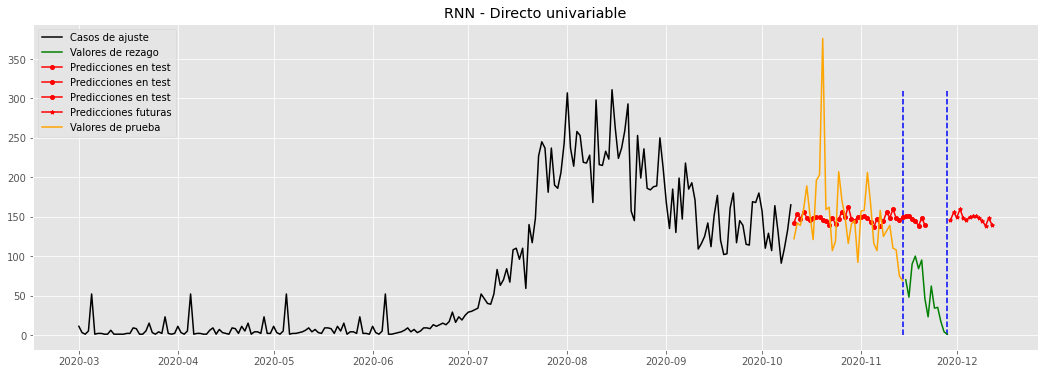

In [15]:
#@title 
#save the model
best_model.save(rnn_direct_dir+'rnn_direct_univariate_model.h5')
scalerfile = rnn_direct_dir+'scaler.pkl'
pkl.dump(bga_scaler, open(scalerfile, 'wb'),  protocol=pkl.HIGHEST_PROTOCOL)

# plots
fig_plor2 = utils.plot_serie_with_next_window_prediction(best_model,
                                       final_data_train,
                                       final_data_test,
                                       bga_scaler,
                                       base_dset_params,
                                       final_data_test.keys().values.tolist().index('BUCARAMANGA'),
                                       recursive=False,
                                       title='RNN - Directo univariable')

### F. Modelo RNN - autorregresivo univariable (Bucaramanga)

In [ ]:
#@title
# modelo autoregresivo
class autoregressive_model(tf.keras.Model):
  def __init__(self, units, layers,out_steps, num_features):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    # Empaquetar la celdas apiladas LSTM en una red RNN y retornar el estado
    self.rnn_cells = [tf.keras.layers.LSTMCell(units) for _ in range(layers)]
    self.lstm_cell = tf.keras.layers.StackedRNNCells(self.rnn_cells)
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    # la densa predice el numero de dimensiones de salida para cada predicción
    # en este caso siempre es 1 porque solo se quiere predecir la serie de Bga
    self.dense1 = tf.keras.layers.Dense(units*2)
    self.dense2 = tf.keras.layers.Dense(num_features)
  
  def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    x = self.dense1(x) 
    prediction = self.dense2(x)
    return prediction, state

  def call(self, inputs, training=None):
    # Para capturar todas las predicciones a realizar
    predictions = []
    # Iniciar la lstm
    prediction, state = self.warmup(inputs)

    # Insertar la primera predicción 
    predictions.append(prediction)

    # Obtener todas las demás prediccioens
    for n in range(1, self.out_steps):
        # Usando la última predicción como entrada 
        x = prediction
        # Ejecutar cada paso LSTM
        x, state = self.lstm_cell(x, states=state,
                                training=training)
        # Convertir la salida de la LSTM a una predicción
        x = self.dense1(x)
        prediction = self.dense2(x)
        # Almacenar la predicción
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])

    return predictions 

def build_autoregressiv_model(hp):
    # contruir el modelo
    tf.keras.backend.clear_session()
    gc.collect()
    model = autoregressive_model(units=64, layers=3, out_steps=base_dset_params['future_window'],
                                 num_features=base_dset_params['num_features'])
    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]), #hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
                                                  clipvalue=hp.Choice('clipvalue', [1.0,2.0,5.0,10.0])),
                metrics=[tf.metrics.MeanAbsoluteError()])
    
    return model   

In [ ]:
#@title
rnn_direct_aureg = os.path.join('Forecasting_COVID_BGA/trained_models/rnn_autoregresive_univariate/', name_folder, '') 
os.makedirs(rnn_direct_aureg, exist_ok=True)

# crear el objeto que va a ejecutar la optmización del modelo
tuner = kt.Hyperband(
    build_autoregressiv_model,
    objective='val_mean_absolute_error',
    max_epochs=30,
    hyperband_iterations=1,
    seed=seed,
    directory=rnn_direct_aureg,
    project_name='rnn_tuner'
)

# entrenar y optimizar los modelos (esta funcion es similar a fit)
tuner.search(dl_bga_dset_train,
             validation_data=dl_bga_dset_test,
             epochs=30,
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error',
                                                         patience=3,
                                                         mode='min',
                                                         restore_best_weights=True)])

In [ ]:
best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print(vars(best_hyperparameters))
print(best_model.evaluate(dl_bga_dset_test))

### Guardar el modelo

In [ ]:
#@title 
#save the model
best_model.save(rnn_direct_aureg+'rnn_direct_univariate_model.tf', save_format="tf")
best_model.save_weights(filepath=rnn_direct_aureg+'rnn_direct_univariate_weights.h5', save_format='h5')
scalerfile = rnn_direct_aureg+'scaler.pkl'
pkl.dump(bga_scaler, open(scalerfile, 'wb'),  protocol=pkl.HIGHEST_PROTOCOL)

# plots
utils.plot_serie_with_next_window_prediction(best_model,
                                       final_data_train,
                                       final_data_test,
                                       bga_scaler,
                                       base_dset_params['past_window'],
                                       base_dset_params['future_window'],
                                       final_data_test.keys().values.tolist().index('BUCARAMANGA'),
                                       recursive=None,
                                       title='RNN - Autoregresivo univariable')

### G. Modelo RNN - directo multivariable (todas las series)

In [ ]:
#@title
## crear un nuevo conjunto de datos seleccionando todas las series 
## select the data
countries_top = ['Argentina', 'Bangladesh', 'Belgium', 'Brazil', 'Canada', 'Chile', 'Czech Republic',
'France', 'Germany', 'India', 'Indonesia', 'Iran', 'Iraq', 'Israel', 'Italy', 'Mexico',
'Morocco', 'Netherlands', 'Pakistan', 'Peru', 'Philippines', 'Poland', 'Romania',
'Russia', 'Saudi Arabia', 'South Africa', 'Spain', 'Turkey', 'Ukraine', 'United Kingdom',
'United States']
dep_top = ['ANTIOQUIA', 'ATLANTICO', 'CUNDINAMARCA', 'SANTANDER', 'VALLE']
cities_top = ['BARRANQUILLA', 'BOGOTA', 'BUCARAMANGA', 'CALI', 'CARTAGENA', 'MEDELLIN']

series = cities_top + dep_top + countries_top

base_dset_params['feature_dim'] = len(series)

final_data = df_join.loc[(df_join.index >= initial_date)
                         & (df_join.index <= final_date), series]
# serie smoothing
if base_dset_params['smoothing']:
    final_data = final_data.rolling(base_dset_params['smooth']).mean().fillna(0)

# data split
final_data_train = final_data.loc[final_data.index <= train_final_date]
final_data_test = final_data.loc[final_data.index > train_final_date]
# train
bga_data_train, bga_scaler = dataset.series_transformer(
    final_data_train,
    standarization=True,
    scaler=None)
# test
bga_data_test, bga_scaler = dataset.series_transformer(
    final_data_test,
    standarization=True,
    scaler=bga_scaler)

ax = bga_data_train.rename(columns={'BUCARAMANGA':'train'}).plot(figsize=(12,5), legend=False, title='Series estandarizadas');
bga_data_test.rename(columns={'BUCARAMANGA':'test'}).plot(ax=ax, legend=False);

In [ ]:
dl_bga_dset_train = dataset.windowed_dataset(bga_data_train.values.astype(np.float32),
                                            base_dset_params,
                                            tf_dset=True,
                                            direct_dset=None)

dl_bga_dset_test = dataset.windowed_dataset(bga_data_test.values.astype(np.float32),
                                           base_dset_params,
                                           tf_dset=True,
                                           direct_dset=None)

In [ ]:
def build_standard_model(hp):
    # Extract values from dict.
    batch_size = base_dset_params['batch_size']
    window_size = base_dset_params['past_window']
    future_steps = base_dset_params['future_window']
    shuffle_buffer = base_dset_params['shuffle_buffer']
    feature_dim = base_dset_params['feature_dim']
    stateful = base_dset_params['stateful']

    # clean gpu and previous models
    tf.keras.backend.clear_session()
    gc.collect()
    # build the model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(window_size,feature_dim), batch_size=batch_size))
    # Shape [batch, time, series] => [batch, lstm_units]
    for i in range(hp.Int('num_layers', min_value=1, max_value=3, step=1)):
        model.add(tf.keras.layers.GRU(units=hp.Choice('units_' + str(i), [16, 32, 64, 128]), 
                                      return_sequences=True, stateful=stateful))
    model.add(tf.keras.layers.GRU(units=hp.Choice('units_' + str(i+1), [16, 32, 64, 128]), 
                                   return_sequences=False, stateful=stateful))
    # Shape [batch, lstm_units] => [batch, featuresDenseDim]
    model.add(tf.keras.layers.Dense(hp.Choice('units_' + str(i+2), [16, 32, 64, 128])))
    model.add(tf.keras.layers.Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.5)))
    model.add(tf.keras.layers.Dense(future_steps))
    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.SGD(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]), #hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
                                                  clipvalue=hp.Choice('clipvalue', [1.0,2.0,5.0,10.0])),
                metrics=[tf.metrics.MeanAbsoluteError()])
    
    return model

In [ ]:
rnn_direct_rnn_multi = os.path.join('Forecasting_COVID_BGA/trained_models/rnn_directo_multivariate/', name_folder, '') 
os.makedirs(rnn_direct_rnn_multi, exist_ok=True)

tuner = kt.Hyperband(
    build_standard_model,
    objective='val_mean_absolute_error',
    max_epochs=30,
    hyperband_iterations=1,
    seed=seed,
    directory=rnn_direct_rnn_multi,
    project_name='rnn_tuner'
)

In [ ]:
# entrenar y optimizar los modelos (esta funcion es similar a fit)
tuner.search(dl_bga_dset_train,
             validation_data=dl_bga_dset_test,
             epochs=30,
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error',
                                                         patience=3,
                                                         mode='min',
                                                         restore_best_weights=True)])

In [ ]:
best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print(vars(best_hyperparameters))
print(best_model.evaluate(dl_bga_dset_test))

### Guardar el modelo

In [ ]:
#@title 
#save the model
best_model.save(rnn_direct_rnn_multi+'rnn_direct_multivariate_model.h5')
best_model.save_weights(filepath=rnn_direct_rnn_multi+'rnn_direct_multivariate_weights.h5', save_format='h5')
scalerfile = rnn_direct_rnn_multi+'scaler.pkl'
pkl.dump(bga_scaler, open(scalerfile, 'wb'),  protocol=pkl.HIGHEST_PROTOCOL)

In [ ]:
# plots
utils.plot_serie_with_next_window_prediction(best_model,
                                       final_data_train,
                                       final_data_test,
                                       bga_scaler,
                                       base_dset_params['past_window'],
                                       base_dset_params['future_window'],
                                       col_idx=final_data_test.keys().values.tolist().index('BUCARAMANGA'),
                                       recursive=None,
                                       title='RNN - Directo multivariable')